We propose a Densely Connected Architecture to classify devices as (0-No device) (1- Old device) (2-New device) 

First lets unzip the required directories

In [0]:
!unzip -qq 'drive/My Drive/device_classification/train.zip'
!unzip -qq 'drive/My Drive/device_classification/val.zip'
!unzip -qq 'drive/My Drive/device_classification/test.zip'
!unzip -qq 'drive/My Drive/device_classification/random.zip'

Importing libraries

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import * 
from sklearn.utils import shuffle
#from maskutils import df2imask
import scipy
from shutil import *


In [0]:
#globals 
nclasses=3
size=(224,224,3)
width=size[0]
height=size[1]
depth=size[2]
batch_size=16
seed=1
home='drive/My Drive/device_classification/'
savepath=home+'DEVICErandocc_7_RES_epoch-{epoch:02d}_acc-{acc:.4f}_val_acc-{val_acc:.4f}_loss-{loss:.4f}_val_loss-{val_loss:.4f}_tp-{tp:.4f}_val_tp-{val_tp:.4f}_tn-{tn:.4f}_val_tn-{val_tn:.4f}_auc_{auc:.4f}_val_auc{val_auc:.4f}.h5'


Now we use the Keras DataGenerator to mount the directories for preprocessing.The preprocessing used here are Horizontal flip
,vertical flip, rotation_range upto 90 degrees and brightness range from 0.3 to 0.99.
The Datagenerator loads data to model pipeline at a batch of 16

In [6]:
train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                          rotation_range=90,
                                         brightness_range=[0.3,0.99]).flow_from_directory(
    "train",
    target_size = (width,height),
    color_mode = 'rgb',
    classes=['random','old','new'],
    class_mode='categorical',
    batch_size = batch_size)

val_data_generator = ImageDataGenerator(horizontal_flip=False,vertical_flip=False).flow_from_directory(
    "val",
    target_size = (width,height),
    color_mode = 'rgb',
    classes=['random','old','new'],
    class_mode='categorical',
    batch_size = batch_size)


print ('train Indices:',train_data_generator.class_indices)

print ('val Indices:',val_data_generator.class_indices)

Found 531 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
train Indices: {'random': 0, 'old': 1, 'new': 2}
val Indices: {'random': 0, 'old': 1, 'new': 2}


Lets visualize how a datagenerator augment the images with the above preprocessing functions

(224, 224, 3)


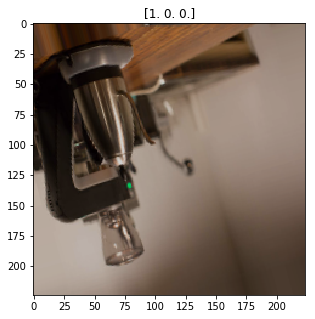

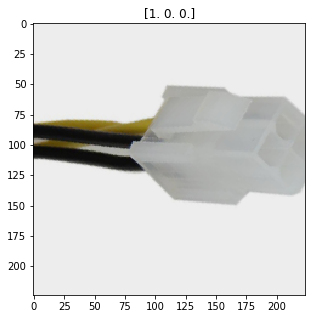

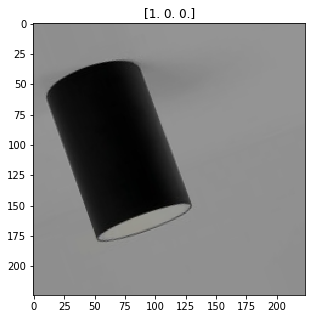

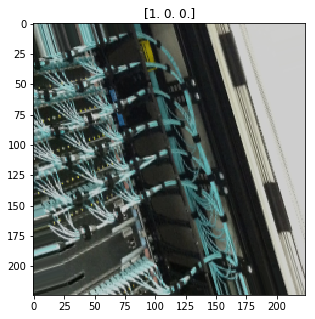

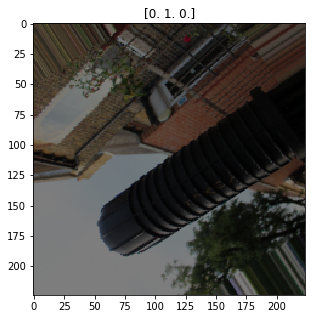

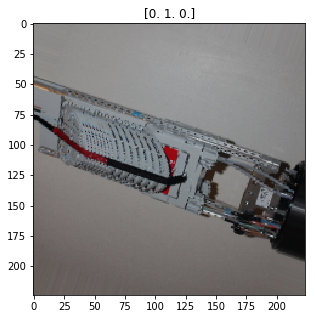

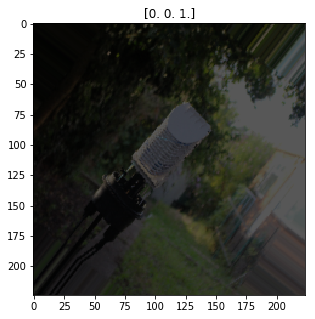

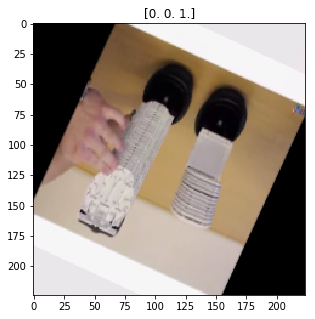

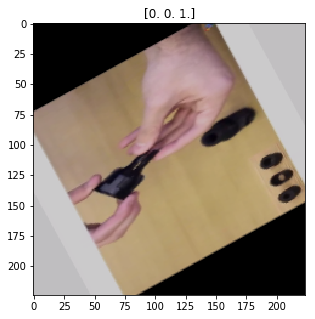

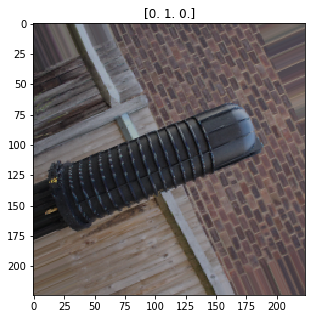

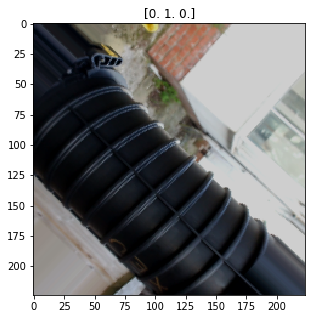

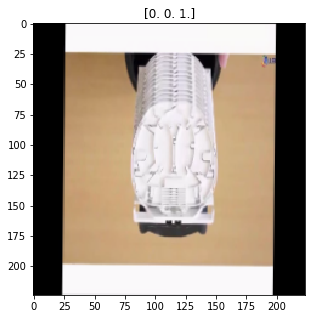

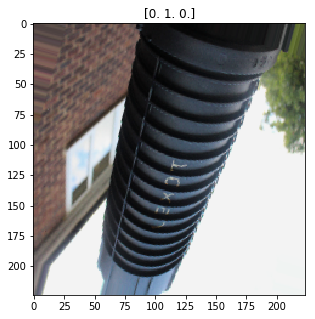

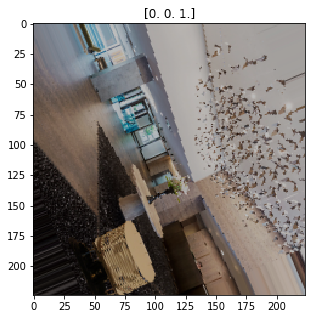

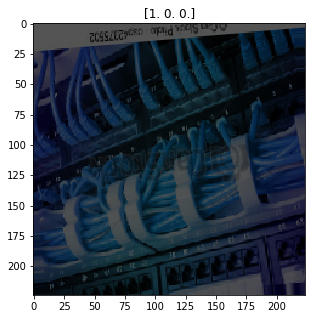

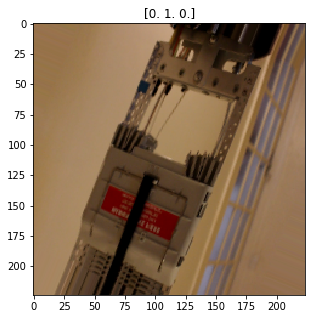

(224, 224, 3)


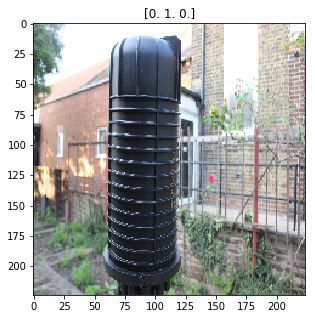

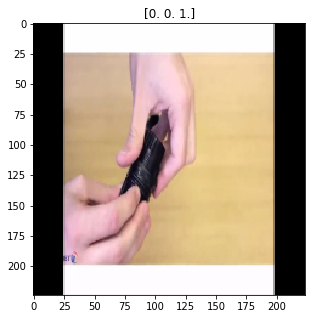

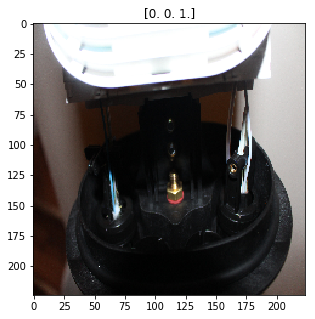

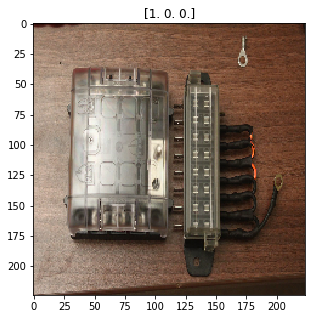

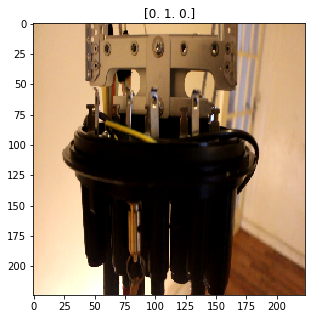

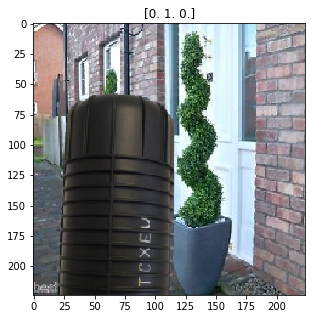

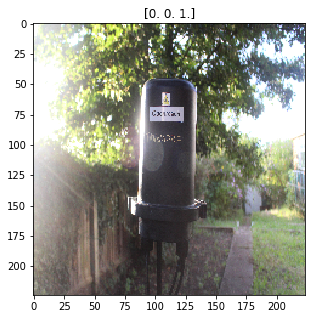

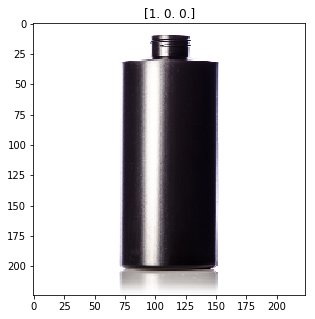

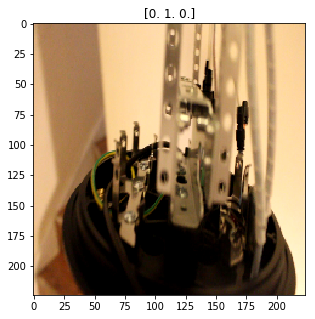

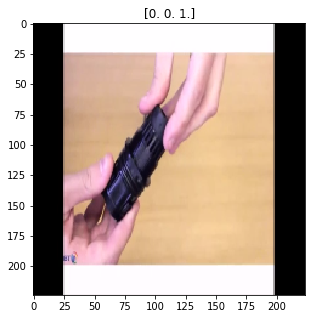

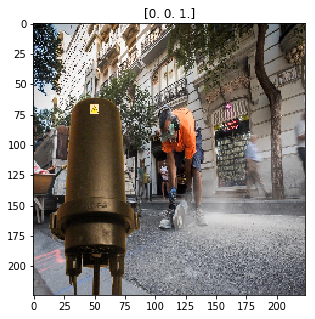

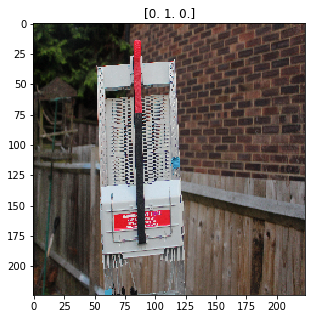

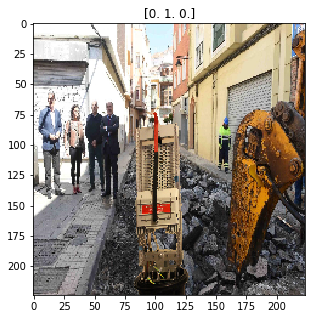

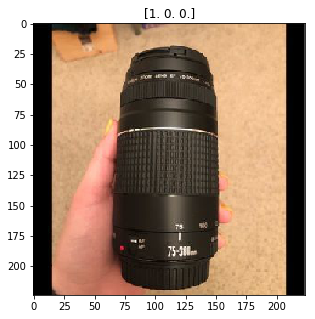

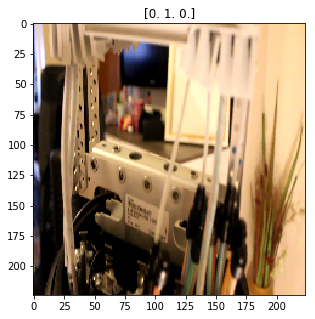

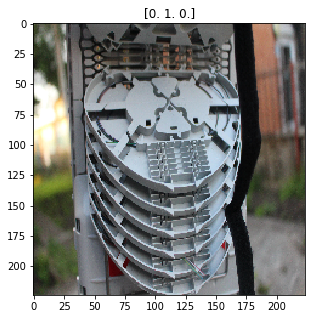

In [7]:
dat,lab=next(train_data_generator)
valdat,vallab=next(val_data_generator)
print (dat[0].shape)
for args in range(batch_size):
  #print (dat[args].shape)
  plt.subplots(1,1,sharex='row',figsize=(5,5))
  plt.title(str(lab[args]))
  plt.imshow(np.squeeze(np.array(dat[args],dtype=np.int32)))
plt.show()

print (valdat[0].shape)
for args in range(batch_size):
  #print (dat[args].shape)
  plt.subplots(1,1,sharex='row',figsize=(5,5))
  plt.title(str(vallab[args]))
  plt.imshow(np.squeeze(np.array(valdat[args],dtype=np.int32)))
plt.show()

For a robust training, we got to make sure that the data is evenly distributed in a range. Like [0,255] here. We can
confirm with the below distribution

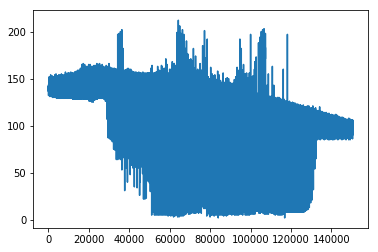

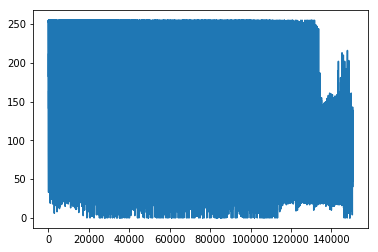

In [8]:
plt.plot(np.ravel(dat[5]))
plt.show()

plt.plot(np.ravel(valdat[5]))
plt.show()

Lets load the cognitive part of the solution. Our model makes use of Dense Convolutional connections to pass on the gradients 
down the blocks, thereby eliminating vanishing gradient problem paving way for stable training

In [10]:
K.clear_session()
model=load_model('model/DEVICErandocc_7_DENSE_epoch-18_acc-0.9988_val_acc-0.9977_loss-0.0070_val_loss-0.0147_tp-799.0000_val_tp-143.0000_tn-1601.0000_val_tn-288.0000_auc_1.0000_val_auc0.9999.h5')
metrics = [tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.FalsePositives(name='fp'),'accuracy',tf.keras.metrics.AUC(name='auc')]
#metrics=None


W0828 22:34:06.386659 140446746253184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 22:34:06.388214 140446746253184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 22:34:06.389479 140446746253184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Save our model for every milestone it achieves with checkpoint

In [11]:
model_checkpoint_acc = ModelCheckpoint(filepath=savepath,
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
model_checkpoint_loss = ModelCheckpoint(filepath=savepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

model_checkpoint_auc = ModelCheckpoint(filepath=savepath,
                                   monitor='val_auc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max',
                                   period=1)

csv_logger = CSVLogger(filename='devicecf.csv',
                       separator=',',
                       append=True)

callbacks = [model_checkpoint_loss,model_checkpoint_acc,csv_logger,model_checkpoint_auc]

W0828 22:35:22.128305 140446746253184 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
W0828 22:35:22.131395 140446746253184 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
W0828 22:35:22.133759 140446746253184 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Training time. Lets train some 50 epochs and see how the model performs

In [12]:
initial_epoch=0
train_count=531
val_count=141
#class_weight={0: 1.2660550458715596, 1: 0.8263473053892215}
#callbacks=None

print('lr:',K.eval(model.optimizer.lr))
#print ('class weight:',class_weight)
print ('batch_size:',batch_size)
history = model.fit_generator(
      train_data_generator,
      steps_per_epoch=train_count/batch_size,
      validation_data=val_data_generator,
      validation_steps=val_count/batch_size,
      epochs=300,
      verbose=1,initial_epoch=initial_epoch,callbacks=callbacks)

lr: 2.5e-05
batch_size: 16


KeyboardInterrupt: ignored

It's time to see what our model has learnt with class activation map

new_device


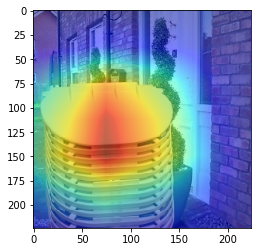

In [20]:
classes=['no_device','old_device','new_device']
#plt.title('Predicted:{} Conf:{}'.format(classes[np.argmax(pred)],pred[:,np.argmax(pred)]))
#create a auxillary model having outputs from layers -4 & -1
x=cv2.cvtColor(cv2.resize(cv2.imread('trial.jpg'),(width,height)),cv2.COLOR_BGR2RGB)
blob=np.expand_dims(x,axis=0)
inputs=model.input
outputs=(model.layers[-4].output,model.layers[-1].output)
new_model=Model(inputs=inputs,outputs=outputs)
#we will have activation from 1664 feature maps and softmax outputs
conv_out,pred_vec=new_model.predict(blob)
pred=np.argmax(pred_vec)
conv_out=np.squeeze(conv_out)
#resize 7,7,1664 feature maps to 224,224,1664
mat = scipy.ndimage.zoom(conv_out, (32, 32, 1), order=1)
#print (mat.shape)
weights=new_model.layers[-1].get_weights()[0]
#segregate weights of highest predicted class
weights = weights[:, np.argmax(pred_vec)]
#dot product the resized feature map with  segregated weights
final_op=np.dot(mat.reshape(224*224,1664),weights).reshape(224,224)

print (classes[pred])
#plot the resulting feature map and input image together     
plt.imshow(x)
plt.imshow(final_op,cmap='jet',alpha=0.5)
plt.show()